In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras 
import tensorflow as tf

Using TensorFlow backend.


In [2]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.losses import mse
from keras import backend as K

In [3]:
archs = np.array([[-1,-1],
                  [2,-2],
                  [4,6],
                  [-2,5]])

In [4]:
X,Y = archs.T

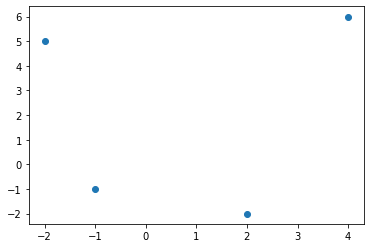

In [5]:
plt.scatter(X,Y)

In [6]:
def generate_data (archs, n_points, noise=0.1):
    k = len(archs)
    X,Y = archs.T 
    rand = np.random.uniform (0,1,[k,n_points])
    rand = (rand/np.sum(rand,axis=0)).T
    data = np.matmul(rand,archs)
    data = data + np.random.normal(0,noise,size=data.shape)
    return data

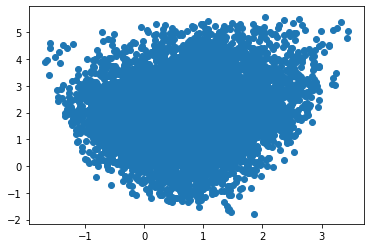

In [7]:
x_train = generate_data (archs,10000,noise=0.01)
x_test = generate_data (archs,1000,noise=0.01)

dataX,dataY = x_train.T
plt.scatter(dataX,dataY)

In [8]:
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim), stddev=0.01)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

original_dim = x_train.shape[1]
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])

# network parameters
input_shape = (original_dim, )
intermediate_dim = 16
batch_size = 256
latent_dim = 16
epochs = 20

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='linear')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

models = (encoder, decoder)
data = (x_test, x_test)


reconstruction_loss = mse(inputs, outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 2)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 16)           48          encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 16)           272         dense_1[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 16)           272         dense_1[0][0]                    
____________________________________________________________________________________________

/home/sbailo/anaconda3/envs/archetypes/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 10000 samples, validate on 1000 samples
Epoch 1/20
10000/10000 [==============================] - 1s 94us/step - loss: 7.2925 - val_loss: 4.5108
Epoch 2/20
10000/10000 [==============================] - 0s 17us/step - loss: 3.1944 - val_loss: 2.1106
Epoch 3/20
10000/10000 [==============================] - 0s 17us/step - loss: 1.5648 - val_loss: 1.1361
Epoch 4/20
10000/10000 [==============================] - 0s 17us/step - loss: 0.9244 - val_loss: 0.7474
Epoch 5/20
10000/10000 [==============================] - 0s 24us/step - loss: 0.6396 - val_loss: 0.5441
Epoch 6/20
10000/10000 [==============================] - 0s 17us/step - loss: 0.4784 - val_loss: 0.4186
Epoch 7/20
10000/10000 [==============================] - 0s 17us/step - loss: 0.3741 - val_loss: 0.3341
Epoch 8/20
10000/10000 [==============================] - 0s 20us/step - loss: 0.3006 - val_loss: 0.2715
Epoch 9/20
10000/10000 [==============================] - 0s 34us/step - loss: 0.2456 - val_loss: 0.2254
Epoch 

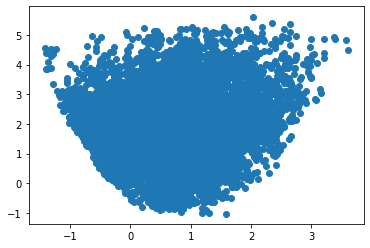

In [9]:
x_pred = vae.predict(x_train)
dataX,dataY = x_pred.T
plt.scatter(dataX,dataY)


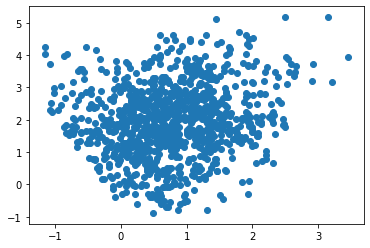

In [10]:
x_pred = vae.predict(x_test)
dataX,dataY = x_pred.T
plt.scatter(dataX,dataY)
